In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# importowanie danych
from keras.datasets import mnist

# klasyczne klasyfikatory
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

# sieci neuronowe
from keras import models
from keras import layers
from keras.utils import to_categorical

# walidacja krzyżowa
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# reprezentacja wyników
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# markdown
from IPython.display import Markdown as md

##### funkcje pomocnicze

In [2]:
SZ=28
affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR

def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
    return img

def showOpencvImage(image, title="", isGray=False):
    fig = plt.figure(figsize=(6, 6))
    plt.title(title)
    plt.axis("off")
    plt.imshow(image, cmap = 'gray')
    plt.show()
    
    
def openCVHOG(im):
    winSize = (20,20)
    blockSize = (10,10)
    blockStride = (5,5)
    cellSize = (10,10)
    nbins = 9
    derivAperture = 1
    winSigma = -1.
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 1
    nlevels = 64
    signedGradients = True

    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, signedGradients)
    descriptor = np.ravel(hog.compute(im))
    
    return descriptor

### Trening klasycznych klasyfikatorów (dane z wyrównaniem)

In [3]:
# import danych
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

(28, 28)
(28, 28)


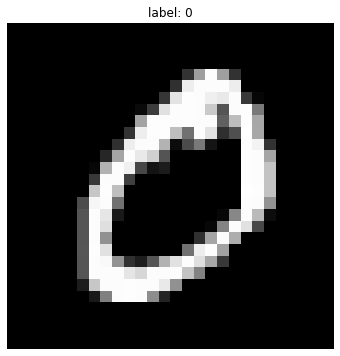

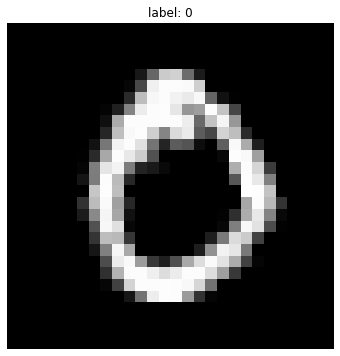

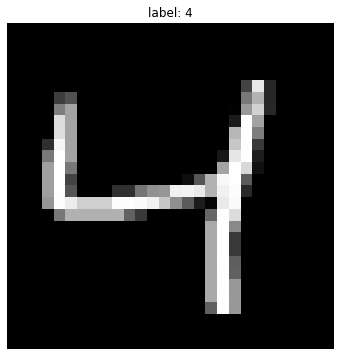

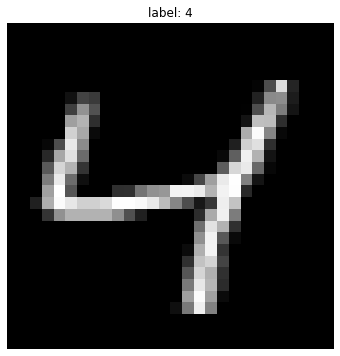

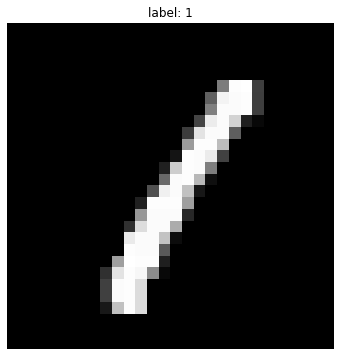

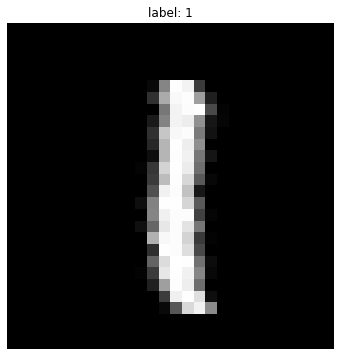

In [4]:
# prezentacja danych
print(train_images[0].shape)

# "prostowanie" cyfr
train_deskewed = np.asarray([deskew(im) for im in train_images])
test_deskewed = np.asarray([deskew(im) for im in test_images])

print(train_deskewed[0].shape)

# wyświetlanie rezultatu
for i in range(3):
    showOpencvImage(train_images[i+1], title=f"label: {train_labels[i+1]}")
    showOpencvImage(train_deskewed[i+1], title=f"label: {train_labels[i+1]}")

In [5]:
# HOG dla danych wyprostowanych

hog_train_deskewed = [openCVHOG(im) for im in train_deskewed]
hog_test_deskewed = [openCVHOG(im) for im in test_deskewed]
print("###########################################\nTrain:\n###########################################")
print(f"len(hog_train_deskewed): \t{len(hog_train_deskewed)}")
print(f"hog_train_deskewed[0].shape:\t{hog_train_deskewed[0].shape}")
train_data_deskewed = np.float32(hog_train_deskewed).reshape(-1,81)
print(f"train_data_deskewed.shape:\t{train_data_deskewed.shape}")
print("###########################################\nTest:\n###########################################")
print(f"len(hog_test_deskewed):  \t{len(hog_test_deskewed)}")
print(f"hog_test_deskewed[0].shape:\t{hog_test_deskewed[0].shape}")
test_data_deskewed = np.float32(hog_test_deskewed).reshape(-1,81)
print(f"test_data_deskewed.shape:\t{test_data_deskewed.shape}")

###########################################
Train:
###########################################
len(hog_train_deskewed): 	60000
hog_train_deskewed[0].shape:	(81,)
train_data_deskewed.shape:	(60000, 81)
###########################################
Test:
###########################################
len(hog_test_deskewed):  	10000
hog_test_deskewed[0].shape:	(81,)
test_data_deskewed.shape:	(10000, 81)


#### SVM dla parametrów domyślnych

In [6]:
# model z domyślnymi parametrami

model = svm.SVC()
model.fit(train_data_deskewed[0:700],train_labels[0:700])
pred_labels = model.predict(test_data_deskewed[0:700,:])

svm_default_deskewed = accuracy_score(test_labels[0:700], pred_labels)

print(f"accuracy: {svm_default_deskewed}")
print(confusion_matrix(test_labels[0:700], pred_labels))
print(classification_report(test_labels[0:700], pred_labels))

accuracy: 0.9142857142857143
[[59  0  0  0  1  0  0  0  0  0]
 [ 0 84  0  0  0  0  0  0  0  0]
 [ 0  0 71  0  0  0  2  3  0  1]
 [ 0  0  1 68  0  4  0  0  0  0]
 [ 0  0  0  0 69  0  5  0  0  0]
 [ 0  0  0  0  0 62  1  1  0  0]
 [ 1  0  0  0  0  0 60  0  0  0]
 [ 0  0  6  9  0  0  0 52  1  2]
 [ 1  0  3  1  1  0  1  1 49  6]
 [ 0  0  1  0  2  2  2  0  1 66]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98        60
           1       1.00      1.00      1.00        84
           2       0.87      0.92      0.89        77
           3       0.87      0.93      0.90        73
           4       0.95      0.93      0.94        74
           5       0.91      0.97      0.94        64
           6       0.85      0.98      0.91        61
           7       0.91      0.74      0.82        70
           8       0.96      0.78      0.86        63
           9       0.88      0.89      0.89        74

    accuracy                           0.91 

#### SVM dla parametrów wyszukanych przez GridSearchCV

In [7]:
# model z dostrojonymi parametrami za pomocą gridsearch
parameters = {'gamma':(0.5, 0.7, 0.9), 'C': np.linspace(start = 1, stop = 15, num = 10)}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, scoring='accuracy', cv=StratifiedKFold())
clf.fit(train_data_deskewed[0:700],train_labels[0:700])
params = clf.best_params_
my_svc = clf.best_estimator_
print("Chosing params: ", params)

# predykcja dla danych testowych
pred_labels = my_svc.predict(test_data_deskewed[0:700,:])

# jakoś predykcji: dokładność

svm_gscv_deskewed = accuracy_score(test_labels[0:700], pred_labels)

print(f"accuracy: {svm_gscv_deskewed}")
print(confusion_matrix(test_labels[0:700], pred_labels))
print(classification_report(test_labels[0:700], pred_labels))

Chosing params:  {'C': 4.111111111111111, 'gamma': 0.5}
accuracy: 0.9328571428571428
[[59  0  0  0  0  0  1  0  0  0]
 [ 0 84  0  0  0  0  0  0  0  0]
 [ 0  0 73  0  0  0  1  3  0  0]
 [ 0  0  1 68  0  4  0  0  0  0]
 [ 0  0  0  0 73  0  1  0  0  0]
 [ 0  0  0  0  0 62  1  1  0  0]
 [ 1  0  0  0  1  1 58  0  0  0]
 [ 0  0  7  6  0  0  0 55  0  2]
 [ 1  0  3  1  1  0  0  0 55  2]
 [ 0  0  1  0  3  2  1  0  1 66]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98        60
           1       1.00      1.00      1.00        84
           2       0.86      0.95      0.90        77
           3       0.91      0.93      0.92        73
           4       0.94      0.99      0.96        74
           5       0.90      0.97      0.93        64
           6       0.92      0.95      0.94        61
           7       0.93      0.79      0.85        70
           8       0.98      0.87      0.92        63
           9       0.94      0.89      0.92

#### RFC dla parametrów domyślnych

In [8]:
rfc = RandomForestClassifier()
rfc.fit(train_data_deskewed[0:700],train_labels[0:700])
pred_labels = rfc.predict(test_data_deskewed[0:700])

rfc_default_deskewed = accuracy_score(test_labels[0:700], pred_labels)

print(f"accuracy: {rfc_default_deskewed}")
print(confusion_matrix(test_labels[0:700], pred_labels))
print(classification_report(test_labels[0:700], pred_labels))

accuracy: 0.9085714285714286
[[56  0  0  0  1  2  1  0  0  0]
 [ 0 84  0  0  0  0  0  0  0  0]
 [ 0  2 72  0  0  0  0  3  0  0]
 [ 0  0  1 67  1  3  0  0  1  0]
 [ 0  0  0  0 70  0  4  0  0  0]
 [ 1  0  0  0  0 61  0  1  1  0]
 [ 0  0  0  0  0  1 59  0  0  1]
 [ 0  0  8  7  1  0  0 53  1  0]
 [ 1  1  2  2  2  1  0  0 47  7]
 [ 0  0  1  0  2  1  1  0  2 67]]
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        60
           1       0.97      1.00      0.98        84
           2       0.86      0.94      0.89        77
           3       0.88      0.92      0.90        73
           4       0.91      0.95      0.93        74
           5       0.88      0.95      0.92        64
           6       0.91      0.97      0.94        61
           7       0.93      0.76      0.83        70
           8       0.90      0.75      0.82        63
           9       0.89      0.91      0.90        74

    accuracy                           0.91 

#### RFC dla parametrów dostrojonych

In [9]:
# analogicznie dla lasu losowego: tworzenie modelu -> szkolenie -> predykcja -> wyświetlanie rezultatów

parameters = {'n_estimators': range(10, 131, 30), 'max_depth': (10, 15, 25, None), 'criterion': ('gini', 'entropy')}
rfc = RandomForestClassifier()
clf = GridSearchCV(rfc, parameters, scoring='accuracy', cv=StratifiedKFold())
clf.fit(train_data_deskewed[0:700],train_labels[0:700])
params = clf.best_params_
my_rfc = clf.best_estimator_
print("Chosing params: ", params)

pred_labels = my_rfc.predict(test_data_deskewed[0:700])

rfc_gscv_deskewed = accuracy_score(test_labels[0:700], pred_labels)

print(f"accuracy: {rfc_gscv_deskewed}")
print(confusion_matrix(test_labels[0:700], pred_labels))
print(classification_report(test_labels[0:700], pred_labels))

Chosing params:  {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}
accuracy: 0.9185714285714286
[[58  0  0  0  0  2  0  0  0  0]
 [ 0 84  0  0  0  0  0  0  0  0]
 [ 0  2 72  0  0  0  0  3  0  0]
 [ 0  0  1 69  0  3  0  0  0  0]
 [ 0  0  0  0 72  0  2  0  0  0]
 [ 1  0  0  0  0 62  0  0  1  0]
 [ 0  0  0  0  0  1 60  0  0  0]
 [ 0  0  6  7  1  0  0 55  1  0]
 [ 1  1  3  3  0  1  0  0 45  9]
 [ 0  0  1  0  1  1  1  1  3 66]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        60
           1       0.97      1.00      0.98        84
           2       0.87      0.94      0.90        77
           3       0.87      0.95      0.91        73
           4       0.97      0.97      0.97        74
           5       0.89      0.97      0.93        64
           6       0.95      0.98      0.97        61
           7       0.93      0.79      0.85        70
           8       0.90      0.71      0.80        63
           9       0.8

### Klasyczne klasyfikatory (dane bez wyrównania)

In [10]:
# tym razem nie używamy funkccji deskew, nie wyrównujemy naszych cyfr

hog_train = [openCVHOG(im) for im in train_images]
hog_test = [openCVHOG(im) for im in test_images]
train_data = np.float32(hog_train).reshape(-1,81)
test_data = np.float32(hog_test).reshape(-1,81)

In [11]:
# model z domyślnymi parametrami

model = svm.SVC()
model.fit(train_data[0:700],train_labels[0:700])
pred_labels = model.predict(test_data[0:700,:])

svm_default_nondeskewed = accuracy_score(test_labels[0:700], pred_labels)

print(f"accuracy: {svm_default_nondeskewed}")
print(confusion_matrix(test_labels[0:700], pred_labels))
print(classification_report(test_labels[0:700], pred_labels))

accuracy: 0.9014285714285715
[[59  0  0  0  1  0  0  0  0  0]
 [ 0 84  0  0  0  0  0  0  0  0]
 [ 0  1 72  0  0  0  1  3  0  0]
 [ 0  0  1 69  0  2  0  1  0  0]
 [ 0  1  0  0 66  0  6  0  0  1]
 [ 0  1  0  0  0 61  0  0  0  2]
 [ 1  0  0  0  3  0 56  0  0  1]
 [ 0  0  8  9  0  0  0 53  0  0]
 [ 2  0  3  3  1  0  1  0 42 11]
 [ 0  0  0  0  0  1  1  2  1 69]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.97        60
           1       0.97      1.00      0.98        84
           2       0.86      0.94      0.89        77
           3       0.85      0.95      0.90        73
           4       0.93      0.89      0.91        74
           5       0.95      0.95      0.95        64
           6       0.86      0.92      0.89        61
           7       0.90      0.76      0.82        70
           8       0.98      0.67      0.79        63
           9       0.82      0.93      0.87        74

    accuracy                           0.90 

In [12]:
# postępujemy identycznie jak w przypadku danych z wyrównaniem

parameters = {'gamma':(0.5, 0.7, 0.9), 'C': np.linspace(start = 1, stop = 15, num = 10)}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, scoring='accuracy', cv=StratifiedKFold())
clf.fit(train_data[0:700],train_labels[0:700])
params = clf.best_params_
my_svc = clf.best_estimator_
print("Chosing params: ", params)

pred_labels = my_svc.predict(test_data[0:700])

svm_gscv_nondeskewed = accuracy_score(test_labels[0:700], pred_labels)

print(f"accuracy: {svm_gscv_nondeskewed}")
print(confusion_matrix(test_labels[0:700], pred_labels))
print(classification_report(test_labels[0:700], pred_labels))

Chosing params:  {'C': 2.5555555555555554, 'gamma': 0.5}
accuracy: 0.9071428571428571
[[60  0  0  0  0  0  0  0  0  0]
 [ 0 84  0  0  0  0  0  0  0  0]
 [ 0  1 70  0  0  0  1  5  0  0]
 [ 0  0  1 70  0  2  0  0  0  0]
 [ 0  1  0  0 67  0  5  0  0  1]
 [ 0  1  0  0  0 62  0  1  0  0]
 [ 1  0  0  0  2  0 56  0  2  0]
 [ 0  0 12  6  0  0  0 51  0  1]
 [ 2  0  3  1  1  2  1  1 47  5]
 [ 0  0  0  0  0  1  1  2  2 68]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        60
           1       0.97      1.00      0.98        84
           2       0.81      0.91      0.86        77
           3       0.91      0.96      0.93        73
           4       0.96      0.91      0.93        74
           5       0.93      0.97      0.95        64
           6       0.88      0.92      0.90        61
           7       0.85      0.73      0.78        70
           8       0.92      0.75      0.82        63
           9       0.91      0.92      0.9

In [13]:
rfc = RandomForestClassifier()
rfc.fit(train_data[0:700],train_labels[0:700])
pred_labels = rfc.predict(test_data[0:700])

rfc_default_nondeskewed = accuracy_score(test_labels[0:700], pred_labels)

print(f"accuracy: {rfc_default_nondeskewed}")
print(confusion_matrix(test_labels[0:700], pred_labels))
print(classification_report(test_labels[0:700], pred_labels))

accuracy: 0.8728571428571429
[[57  0  0  0  1  1  1  0  0  0]
 [ 0 84  0  0  0  0  0  0  0  0]
 [ 0  0 68  3  0  0  2  4  0  0]
 [ 0  0  3 66  0  3  0  0  1  0]
 [ 0  1  0  0 67  0  6  0  0  0]
 [ 0  1  0  0  0 57  3  0  2  1]
 [ 0  0  1  0  4  1 55  0  0  0]
 [ 0  0  4 11  0  0  0 54  0  1]
 [ 1  0  2  3  4  5  1  0 39  8]
 [ 1  0  1  0  2  0  1  1  4 64]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        60
           1       0.98      1.00      0.99        84
           2       0.86      0.88      0.87        77
           3       0.80      0.90      0.85        73
           4       0.86      0.91      0.88        74
           5       0.85      0.89      0.87        64
           6       0.80      0.90      0.85        61
           7       0.92      0.77      0.84        70
           8       0.85      0.62      0.72        63
           9       0.86      0.86      0.86        74

    accuracy                           0.87 

In [14]:
# tak samo dla lasu losowego

parameters = {'n_estimators': range(10, 131, 30), 'max_depth': (10, 15, 25), 'criterion': ('gini', 'entropy')}
rfc = RandomForestClassifier()
clf = GridSearchCV(rfc, parameters, scoring='accuracy', cv=StratifiedKFold())
clf.fit(train_data[0:700],train_labels[0:700])
params = clf.best_params_
my_rfc = clf.best_estimator_
print("Chosing params: ", params)

pred_labels = my_rfc.predict(test_data[0:700])

rfc_gscv_nondeskewed = accuracy_score(test_labels[0:700], pred_labels)

print(f"accuracy: {rfc_gscv_nondeskewed}")
print(confusion_matrix(test_labels[0:700], pred_labels))
print(classification_report(test_labels[0:700], pred_labels))

Chosing params:  {'criterion': 'gini', 'max_depth': 15, 'n_estimators': 130}
accuracy: 0.8728571428571429
[[57  0  0  0  1  1  1  0  0  0]
 [ 0 84  0  0  0  0  0  0  0  0]
 [ 0  0 66  3  0  0  2  5  0  1]
 [ 0  0  2 66  0  4  0  0  1  0]
 [ 0  1  0  0 65  0  7  0  0  1]
 [ 0  2  1  0  0 56  1  1  2  1]
 [ 1  0  0  0  4  2 54  0  0  0]
 [ 0  0  3 11  0  0  0 55  0  1]
 [ 1  0  2  1  3  4  0  1 42  9]
 [ 1  0  0  0  2  0  1  1  3 66]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        60
           1       0.97      1.00      0.98        84
           2       0.89      0.86      0.87        77
           3       0.81      0.90      0.86        73
           4       0.87      0.88      0.87        74
           5       0.84      0.88      0.85        64
           6       0.82      0.89      0.85        61
           7       0.87      0.79      0.83        70
           8       0.88      0.67      0.76        63
           9       0.8

In [31]:
# Po przeprowadzeniu wielu prób wyniki były bardzo zbliżone do siebie, jednak nie zawsze identyczne, stąd rozwiązanie ze zmiennymi w tabeli i zawsze takim samym zdaniem podsumowania :)

md(f"### Wnioski:\n\
Zbierając wszystkie wyniki widzimy:\n\n\
|                 | default result | GSCV result |\n\
|---------------|:--------------:|:-----------:|\n\
| SVM deskewed    |     {svm_default_deskewed:.5f}    |   {svm_gscv_deskewed:.5f}   |\n\
| SVM nondeskewed |     {svm_default_nondeskewed:.5f}    |   {svm_gscv_nondeskewed:.5f}   |\n\
| RFC deskewed    |     {rfc_default_deskewed:.5f}    |   {rfc_gscv_deskewed:.5f}   |\n\
| RFC nondeskewed |     {rfc_default_nondeskewed:.5f}    |   {rfc_gscv_nondeskewed:.5f}   |\n\
\n\
W naszej tabeli widzimy jasno, że zarówno RFC jak i SVM radzą sobie lepiej na danych wyrównanych zarówno z użyciem walidacji krzyżowej jak i bez niej.")

### Wnioski:
Zbierając wszystkie wyniki widzimy:

|                 | default result | GSCV result |
|---------------|:--------------:|:-----------:|
| SVM deskewed    |     0.91429    |   0.93286   |
| SVM nondeskewed |     0.90143    |   0.90714   |
| RFC deskewed    |     0.90857    |   0.91857   |
| RFC nondeskewed |     0.87286    |   0.87286   |

W naszej tabeli widzimy jasno, że zarówno RFC jak i SVM radzą sobie lepiej na danych wyrównanych zarówno z użyciem walidacji krzyżowej jak i bez niej.

### Sieci neuronowe (dane z wyrównaniem)

In [16]:
# Tworzenie modelu oraz dodanie dwóch warstw

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(81,)))
network.add(layers.Dense(10, activation='softmax'))

network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [17]:
encoded_train_labels = to_categorical(train_labels)
encoded_test_labels = to_categorical(test_labels)

print(encoded_test_labels)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [18]:
network.fit(train_data_deskewed, encoded_train_labels, epochs=15, batch_size=128)

Epoch 1/15
469/469 [==============================] - 1s 2ms/step - loss: 0.6302 - accuracy: 0.8671
Epoch 2/15
469/469 [==============================] - 1s 1ms/step - loss: 0.1328 - accuracy: 0.9594
Epoch 3/15
469/469 [==============================] - 1s 1ms/step - loss: 0.1143 - accuracy: 0.9639
Epoch 4/15
469/469 [==============================] - 1s 1ms/step - loss: 0.1044 - accuracy: 0.9678
Epoch 5/15
469/469 [==============================] - 1s 1ms/step - loss: 0.0918 - accuracy: 0.9711
Epoch 6/15
469/469 [==============================] - 1s 1ms/step - loss: 0.0892 - accuracy: 0.9718
Epoch 7/15
469/469 [==============================] - 1s 1ms/step - loss: 0.0812 - accuracy: 0.9741
Epoch 8/15
469/469 [==============================] - 1s 1ms/step - loss: 0.0750 - accuracy: 0.9768
Epoch 9/15
469/469 [==============================] - 1s 1ms/step - loss: 0.0727 - accuracy: 0.9772
Epoch 10/15
469/469 [==============================] - 1s 1ms/step - loss: 0.0729 - accuracy: 0.9767

In [19]:
test_loss, test_acc = network.evaluate(test_data_deskewed, encoded_test_labels)
print('test_acc:', test_acc)

313/313 [==============================] - 0s 670us/step - loss: 0.0740 - accuracy: 0.9771
test_acc: 0.9771000146865845


In [20]:
pred_probabilities = network.predict(test_data_deskewed)
pred_labels = np.argmax(pred_probabilities,-1)

print(f"Accuracy: {accuracy_score(test_labels, pred_labels)}\n")
print(confusion_matrix(test_labels, pred_labels))
print(classification_report(test_labels, pred_labels))

Accuracy: 0.9771

[[ 970    0    2    0    2    0    2    2    1    1]
 [   2 1118    0    1    0    0    3    8    3    0]
 [   0    0 1000    7    1    0    0   21    3    0]
 [   0    1    3  993    0    1    0   10    2    0]
 [   2    0    3    0  962    1    5    1    3    5]
 [   7    0    1    9    1  859    2    2    5    6]
 [   6    2    1    1    8    1  935    0    3    1]
 [   2    1    6    5    0    0    0 1011    3    0]
 [   0    0    1   12    5    1    0    4  942    9]
 [   3    0    0    1    4    1    2    8    9  981]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       1.00      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.97      0.98      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.96      0.98       892
           6       0.99      0.98      0.98       958
           7      

# Sieci neuronowe (dane bez wyrównania)

In [21]:
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(81,)))
network.add(layers.Dense(10, activation='softmax'))

network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

network.fit(train_data, encoded_train_labels, epochs=15, batch_size=128)

Epoch 1/15
469/469 [==============================] - 1s 1ms/step - loss: 0.7311 - accuracy: 0.8357
Epoch 2/15
469/469 [==============================] - 1s 1ms/step - loss: 0.1887 - accuracy: 0.9413
Epoch 3/15
469/469 [==============================] - 1s 1ms/step - loss: 0.1570 - accuracy: 0.9513: 0s - loss: 0.1571 - accuracy: 0.
Epoch 4/15
469/469 [==============================] - 1s 1ms/step - loss: 0.1404 - accuracy: 0.9553
Epoch 5/15
469/469 [==============================] - 1s 1ms/step - loss: 0.1297 - accuracy: 0.9588
Epoch 6/15
469/469 [==============================] - 1s 1ms/step - loss: 0.1204 - accuracy: 0.9613
Epoch 7/15
469/469 [==============================] - 1s 1ms/step - loss: 0.1116 - accuracy: 0.9632
Epoch 8/15
469/469 [==============================] - 1s 1ms/step - loss: 0.1034 - accuracy: 0.9674
Epoch 9/15
469/469 [==============================] - 1s 1ms/step - loss: 0.1015 - accuracy: 0.9690
Epoch 10/15
469/469 [==============================] - 1s 1ms/step

In [22]:
test_loss, test_acc = network.evaluate(test_data, encoded_test_labels)
print('test_acc:', test_acc)

313/313 [==============================] - 0s 796us/step - loss: 0.0876 - accuracy: 0.9719
test_acc: 0.9718999862670898


In [23]:
pred_probabilities = network.predict(test_data)
pred_labels = np.argmax(pred_probabilities,-1)

print(f"Accuracy score for deskewed data: {accuracy_score(test_labels, pred_labels)}\n")
print(confusion_matrix(test_labels, pred_labels))
print(classification_report(test_labels, pred_labels))

Accuracy score for deskewed data: 0.9719

[[ 954    2    4    0    2    5    9    2    1    1]
 [   0 1128    1    0    0    0    1    2    3    0]
 [   2    1 1012    4    1    0    0   10    2    0]
 [   0    1    7  986    0    7    0    3    6    0]
 [   1    0    1    0  973    0    2    0    1    4]
 [   2    1    1    5    2  867    2    1    5    6]
 [   6    4    2    0   11    4  928    0    3    0]
 [   1   13   24    9    1    1    0  976    3    0]
 [   1    0    7    8    7    5    2    1  929   14]
 [   6    3    1    2   12    8    2    0    9  966]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.95      0.98      0.97      1032
           3       0.97      0.98      0.97      1010
           4       0.96      0.99      0.98       982
           5       0.97      0.97      0.97       892
           6       0.98      0.97      0.97     

#### Wnioski:
|                 | result |
|---------------|:--------------:|
| NN deskewed    |     0.975700    |
| NN nondeskewed |     0.971199    |

Jak widzimy również w tym przypadku model trenowany na danych wyrównanych daje lepsze rezultaty niż model trenowany na danych oryginalnych.

### Zadanie 3 - dane surowe vs hog

In [24]:
# test_hog_deskewed = np.array(np.float32([openCVHOG(deskew(im)) for im in test_images]).reshape(-1,81)).astype('float32')
# train_hog_deskewed = np.array(np.float32([openCVHOG(deskew(im)) for im in train_images]).reshape(-1,81)).astype('float32')

# test_deskewed = np.array(np.float32([deskew(im) for im in test_images]).reshape(-1,784)).astype('float32')
# train_deskewed = np.array(np.float32([deskew(im) for im in train_images]).reshape(-1,28*28)).astype('float32')

In [25]:
# train_images1 = train_images
# train_images1 = (train_images.astype('float32') / 255).reshape((60000, 784))

# test_images1 = test_images
# test_images1 = (test_images.astype('float32') / 255).reshape((-1, 784))

In [26]:
# model_hog = svm.SVC(C=15.5,gamma=0.7)
# model_hog.fit(train_hog_deskewed[0:1000],train_labels[0:1000])

# pred_labels_hog = model_hog.predict(test_hog_deskewed[0:1000])

# model = svm.SVC(C=15.5,gamma=0.7)
# model.fit(train_images1[0:1000],train_labels[0:1000])

# pred_labels = model.predict(test_images1[0:1000])

In [27]:
# print(f"accuracy: {accuracy_score(test_labels[0:1000], pred_labels_hog)}")
# print(confusion_matrix(test_labels[0:1000], pred_labels_hog))
# print(classification_report(test_labels[0:1000], pred_labels_hog))

# print(f"accuracy: {accuracy_score(test_labels[0:1000], pred_labels)}")
# print(confusion_matrix(test_labels[0:1000], pred_labels))
# print(classification_report(test_labels[0:1000], pred_labels))